<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>
 

## Nonlinear Feature Classification Using Kernel PCA

#### Naveen Raj Manoharan
#### Maseeh Department of Civil, Architecture and Environmental Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences

_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Elnara Rustamzade, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/elnara-rustamzade/)

### Executive Summary

Principal Component Analysis (PCA) is a popular linear dimensionality reduction technique that projects data onto directions of maximum variance. While effective for linearly separable data, it falls short in capturing **nonlinear patterns**.

**Kernel PCA** addresses this limitation by mapping the data into a **high-dimensional feature space** using a nonlinear transformation, and then applying PCA in that space. This is achieved implicitly using the **kernel trick**, which computes pairwise similarities between data points without explicitly transforming the data. One commonly used kernel is the **Radial Basis Function (RBF)**, which enables Kernel PCA to capture complex, nonlinear structures in the data.

This technique is particularly beneficial for our case: the `make_moons` dataset from `scikit learn`. The data has a **nonlinear decision boundary** that cannot be effectively separated by linear methods. Logistic regression applied after standard PCA may fail to classify the data correctly. However, applying Kernel PCA first allows us to **unfold the data manifold**, making it **linearly separable** and improving classification accuracy with logistic regression.

In this notebook, we demonstrate the advantages of Kernel PCA over standard PCA using logistic regression as the downstream classifier.



### Load the Required Libraries
The following code loads the required libraries. It is from Professor Michael Pyrcz (@GeostatsGuy), MachineLearning_PCA.ipynb from [GeostatsGuy GitHub](https://geostatsguy.github.io/MachineLearningDemos_Book/MachineLearning_PCA.html).

In [1]:
ignore_warnings = True                                        # ignore warnings?
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, KernelPCA                # PCA program from scikit learn (package for machine learning)
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split            # standardize variables to mean of 0.0 and variance of 1.0
from sklearn.metrics import accuracy_score
import numpy as np                                            # ndarrays for gridded data
import pandas as pd                                           # DataFrames for tabular data
import pandas.plotting as pd_plot                             # pandas plotting functions
import copy                                                   # for deep copies
import os                                                     # set working directory, run executables
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
import matplotlib.ticker as mtick                             # control tick label formatting
import seaborn as sns                                         # advanced plotting
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:
    import warnings
    warnings.filterwarnings('ignore')
cmap = plt.cm.inferno                                         # color map
seed = 42                                                     # random number seed

### Dataset

We begin our analysis by generating synthetic data using scikit-learn's `make_moons` function. This function creates a **two-class dataset** where each class forms a crescent or "moon" shape. The data is inherently **nonlinear and non-convex**, making it a challenging benchmark for linear classification algorithms.

In the plot above, we visualize the predictor features in 2D space. The two classes are clearly interleaved in a curved pattern, illustrating that a **straight line (linear boundary)** cannot effectively separate them. This geometric structure is precisely what motivates the use of **nonlinear dimensionality reduction techniques**, such as **Kernel PCA**, to better unfold the data and make it amenable to linear classifiers like logistic regression.

The small amount of noise (`noise=0.05`) adds slight variations to each data point, simulating more realistic, imperfect data and preventing overfitting.


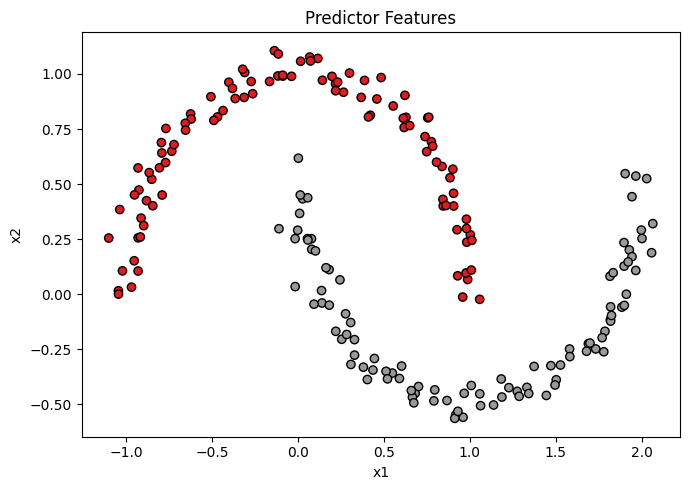

In [2]:
# Generate data
X, y = make_moons(n_samples=200, noise=0.05, random_state=42)


# Create figure
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# Plot: All data
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k')
ax.set_title("Predictor Features")
ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.show()

### Summary Statistics for Tabular Data

There are a lot of efficient methods to calculate summary statistics from tabular data in DataFrames. The describe command provides count, mean, minimum, maximum, and quartiles all in a nice data table.

We use transpose just to flip the table so that features are on the rows and the statistics are on the columns.


In [3]:
# Convert to DataFrame
df = pd.DataFrame(X, columns=["X1", "X2"])
df["Label"] = y

# Display summary statistics
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
X1,200.0,0.502073,0.874501,-1.100568,-0.049588,0.498679,1.010003,2.065082
X2,200.0,0.258090,0.495885,-0.564608,-0.199937,0.252069,0.698381,1.105761
Label,200.0,0.500000,0.501255,0.000000,0.000000,0.500000,1.000000,1.000000


### Standardizing the Features

Before applying PCA or Kernel PCA, it's important to **standardize the features** so that each has a **mean of zero** and **unit variance**.

Although the `make_moons` dataset has features with similar units, standardization is still essential. Many dimensionality reduction techniques, including PCA and Kernel PCA, are sensitive to the **scale of the input features**. Without standardization, one feature could dominate the variance simply due to its numerical range, which would distort the principal components.

For example, if one feature varied between 0 and 1 while another ranged from -100 to 100, PCA would give disproportionate weight to the second feature—even if it wasn’t more informative. This would mislead the transformation and ultimately affect the performance of downstream classifiers like logistic regression.

Thus, we standardize the input features to ensure that **each contributes equally** to the analysis, making our comparisons between PCA and Kernel PCA both fair and meaningful.


In [4]:
# Compute original mean and std
mu = df.mean()
sd = df.std()

# Standardize using StandardScaler
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[["X1", "X2"]] = scaler.fit_transform(df[["X1", "X2"]])

# Print summary
print("Original Mean X1 =", np.round(mu['X1'], 2), ", Original Mean X2 =", np.round(mu['X2'], 2))
print("Original StDev X1 =", np.round(sd['X1'], 2), ", Original StDev X2 =", np.round(sd['X2'], 2))
print("Mean Transformed X1 =", np.round(df_scaled['X1'].mean(), 2), ", Mean Transformed X2 =", np.round(df_scaled['X2'].mean(), 2))
print("Variance Transformed X1 =", df_scaled['X1'].var(), ", Variance Transformed X2 =", df_scaled['X2'].var())

Original Mean X1 = 0.5 , Original Mean X2 = 0.26
Original StDev X1 = 0.87 , Original StDev X2 = 0.5
Mean Transformed X1 = 0.0 , Mean Transformed X2 = -0.0
Variance Transformed X1 = 1.0050251256281406 , Variance Transformed X2 = 1.0050251256281406


### Visualizing Standardization

The plots above show the `make_moons` dataset **before and after standardization**. While the class structure remains unchanged, standardization shifts the feature values to have **zero mean** and **unit variance**, aligning both features on a common scale.

This preprocessing step is crucial for PCA and Kernel PCA, which are sensitive to the variance of each feature. Without standardization, components may be biased toward higher-magnitude features, leading to misleading transformations and poor classification results.


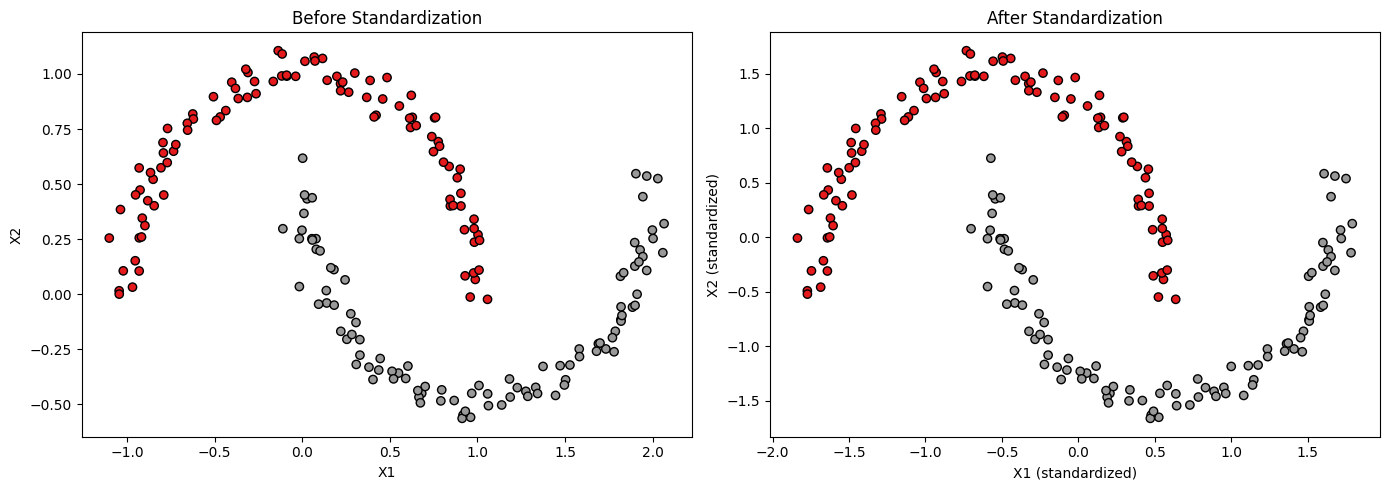

In [5]:
# Plot before and after standardization
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Before standardization
axs[0].scatter(df["X1"], df["X2"], c=df["Label"], cmap=plt.cm.Set1, edgecolor='k')
axs[0].set_title("Before Standardization")
axs[0].set_xlabel("X1")
axs[0].set_ylabel("X2")

# After standardization
axs[1].scatter(df_scaled["X1"], df_scaled["X2"], c=df_scaled["Label"], cmap=plt.cm.Set1, edgecolor='k')
axs[1].set_title("After Standardization")
axs[1].set_xlabel("X1 (standardized)")
axs[1].set_ylabel("X2 (standardized)")

plt.tight_layout()
plt.show()


### Train-Test Split

We split the dataset into **training (65%)** and **testing (35%)** subsets using **stratified sampling**. This ensures that both sets maintain the same class proportions, preventing class imbalance from skewing the evaluation.

The plots below visualize the two subsets. The **training set** is used to fit the logistic regression model, while the **testing set** is used for evaluation.


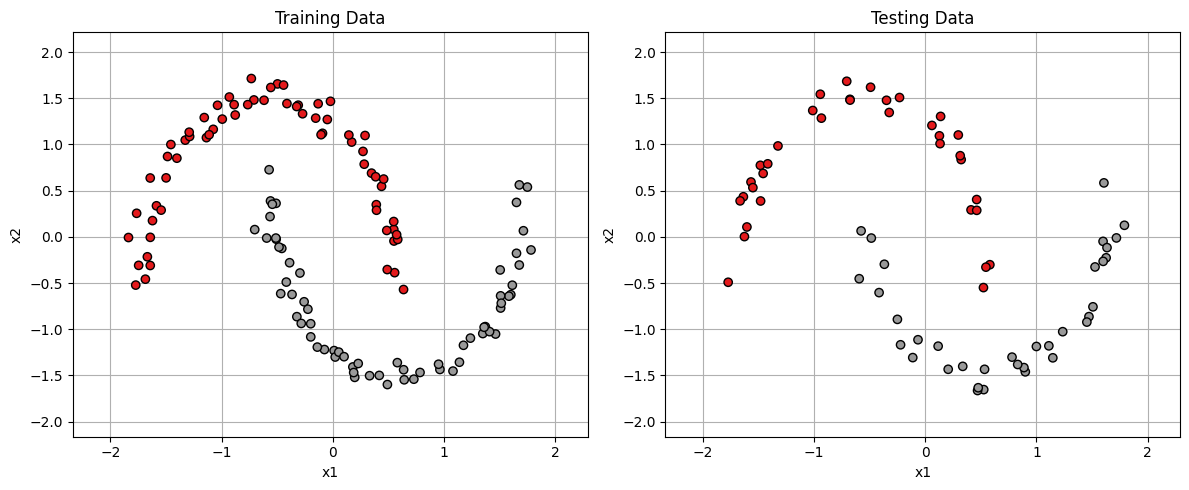

In [6]:
# Train-test split
df_train, df_test = train_test_split(df_scaled, test_size=0.35, random_state=42, stratify=df["Label"])

# Create figure
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Training data only
axs[0].scatter(df_train["X1"], df_train["X2"], c=df_train["Label"], cmap=plt.cm.Set1, edgecolor='k')
axs[0].set_title("Training Data")
axs[0].set_xlabel("x1")
axs[0].set_ylabel("x2")

# Plot 2: Testing data only
axs[1].scatter(df_test["X1"], df_test["X2"], c=df_test["Label"], cmap=plt.cm.Set1, edgecolor='k')
axs[1].set_title("Testing Data")
axs[1].set_xlabel("x1")
axs[1].set_ylabel("x2")

# Adjust layout and fix axis limits to be the same across all
for ax in axs:
    ax.set_xlim(df_scaled["X1"].min() - 0.5, df_scaled["X1"].max() + 0.5)
    ax.set_ylim(df_scaled["X2"].min() - 0.5, df_scaled["X2"].max() + 0.5)
    ax.grid(True)

plt.tight_layout()
plt.show()

### Visualize the Split

Let’s check the consistency and coverage of training and testing with histograms and scatter plots.

1. check to make sure the train and test data cover the range of possible predictor feature combinations
2. Ensure we are not extrapolating beyond the training data with the testing cases

The following code block is from Professor Michael Pyrcz (@GeostatsGuy), MachineLearning_LASSO_regression.ipynb from [GeostatsGuy GitHub](https://geostatsguy.github.io/MachineLearningDemos_Book/MachineLearning_LASSO_regression.html).

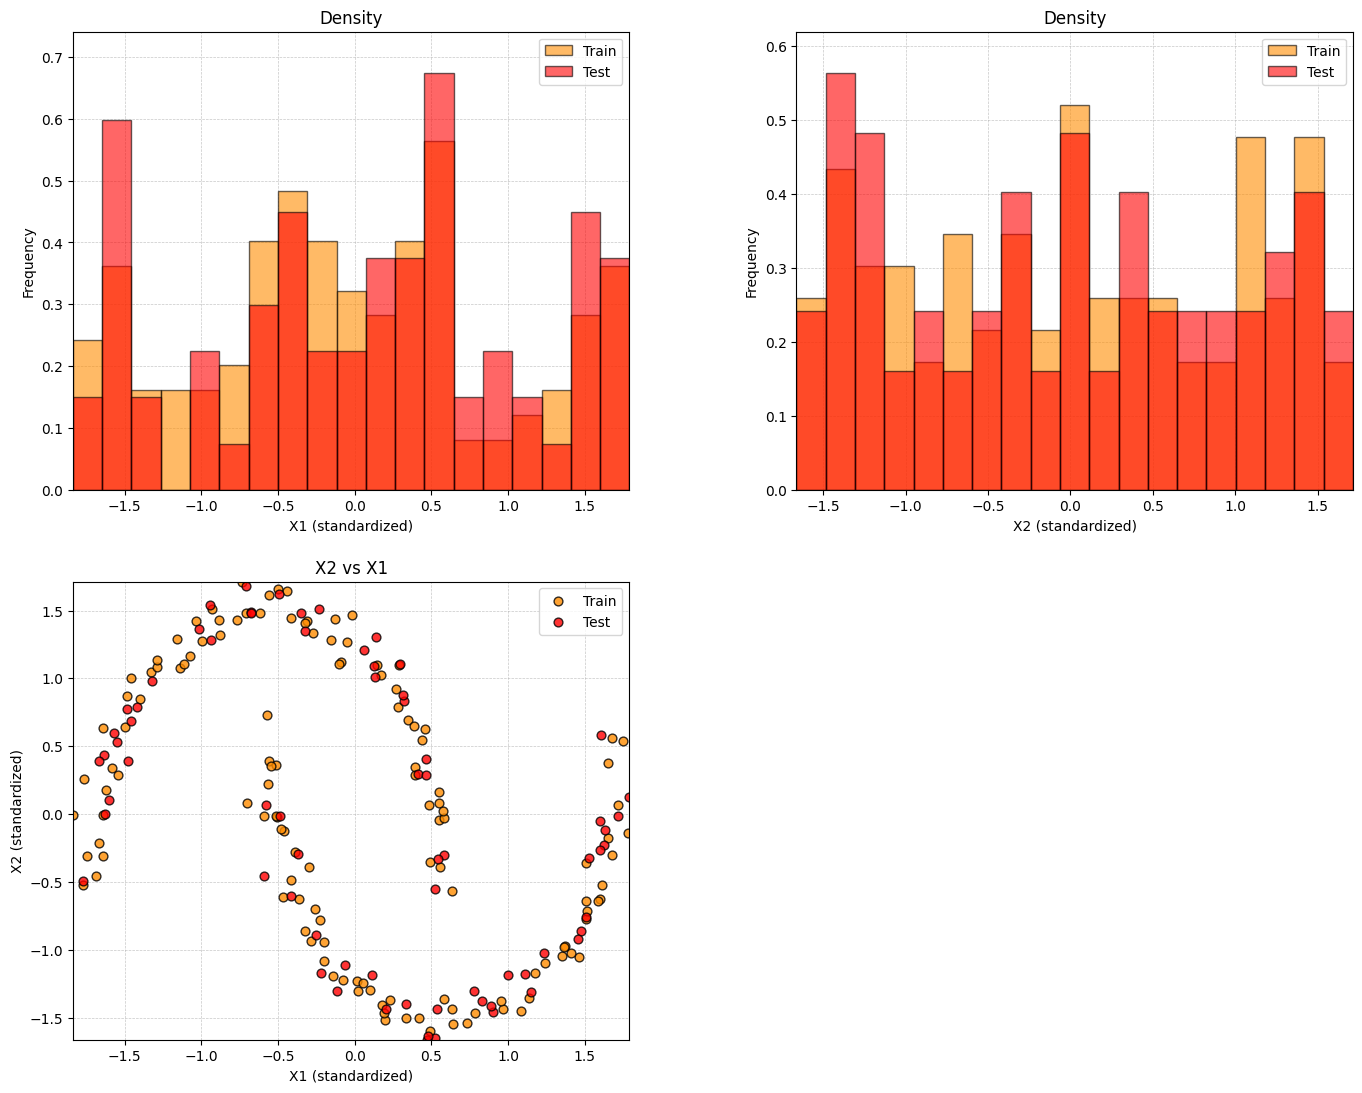

In [9]:
xname = "X1"
yname = "X2"
xunit = "standardized"
yunit = "standardized"
nbins = 20

def add_grid():
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

xmin, xmax = df_scaled[[xname]].min().iloc[0], df_scaled[[xname]].max().iloc[0]
ymin, ymax = df_scaled[[yname]].min().iloc[0], df_scaled[[yname]].max().iloc[0]


plt.subplot(221)
freq1,_,_ = plt.hist(x=df_train[xname], bins=np.linspace(xmin,xmax,nbins), alpha=0.6,
                     edgecolor='black', color='darkorange', density=True, label='Train')
freq2,_,_ = plt.hist(x=df_test[xname], bins=np.linspace(xmin,xmax,nbins), alpha=0.6,
                     edgecolor='black', color='red', density=True, label='Test')
max_freq = max(freq1.max()*1.10, freq2.max()*1.10)
plt.xlabel(f'{xname} ({xunit})'); plt.ylabel('Frequency'); plt.ylim([0.0,max_freq]); plt.title('Density'); add_grid()
plt.xlim([xmin, xmax]); plt.legend(loc='upper right')

plt.subplot(222)
freq1,_,_ = plt.hist(x=df_train[yname], bins=np.linspace(ymin,ymax,nbins), alpha=0.6,
                     edgecolor='black', color='darkorange', density=True, label='Train')
freq2,_,_ = plt.hist(x=df_test[yname], bins=np.linspace(ymin,ymax,nbins), alpha=0.6,
                     edgecolor='black', color='red', density=True, label='Test')
max_freq = max(freq1.max()*1.10, freq2.max()*1.10)
plt.xlabel(f'{yname} ({yunit})'); plt.ylabel('Frequency'); plt.ylim([0.0,max_freq]); plt.title('Density'); add_grid()
plt.xlim([ymin, ymax]); plt.legend(loc='upper right')

plt.subplot(223)
plt.scatter(df_train[xname], df_train[yname], s=40, marker='o', color='darkorange', alpha=0.8, edgecolor='black', label='Train')
plt.scatter(df_test[xname], df_test[yname], s=40, marker='o', color='red', alpha=0.8, edgecolor='black', label='Test')
plt.title('X2 vs X1')
plt.xlabel(f'{xname} ({xunit})')
plt.ylabel(f'{yname} ({yunit})')
plt.legend(); add_grid(); plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.3, hspace=0.2)
plt.show()


### Logistic Regression as a Baseline

Before applying advanced dimensionality reduction techniques, we begin with a **simple logistic regression** model trained directly on the standardized features. Logistic regression is a **linear classifier**, which assumes a linear decision boundary between classes. Although this assumption is clearly violated in the `make_moons` dataset (which has a nonlinear structure), using it provides a **baseline** to compare more complex methods against.

By evaluating the performance of logistic regression without any feature transformation, we can clearly observe the **limitations of linear models on nonlinear data**, and later quantify the gains achieved through PCA and Kernel PCA.

In [10]:
# Step 1: Train logistic regression on original standardized data
clf_orig = LogisticRegression()
clf_orig.fit(df_train[["X1", "X2"]], df_train["Label"])

# Step 2: Predict on both train and test
y_train_pred_orig = clf_orig.predict(df_train[["X1", "X2"]])
y_test_pred_orig = clf_orig.predict(df_test[["X1", "X2"]])

# Step 3: Accuracy
test_accuracy_orig = accuracy_score(df_test["Label"], y_test_pred_orig)
print(f"Logistic Regression (original standardized data) test accuracy: {test_accuracy_orig:.2f}")

Logistic Regression (original standardized data) test accuracy: 0.93


### Visualizing Logistic Regression Predictions

After training the logistic regression model on the standardized features, we evaluate its performance by visualizing the **decision boundary** and **classification accuracy** on both the training and testing datasets.

To do this, we:
1. **Create a meshgrid** over the feature space to generate a smooth background showing the predicted class regions.
2. **Overlay the actual training and testing data**, highlighting which points were **classified correctly** and which were **misclassified**.
3. Display the **decision surface** learned by the logistic regression model.

This visualization helps us:
- Understand how well the linear classifier fits the data.
- Identify patterns in the misclassified points.
- Quantify model performance, especially on the nonlinear structure of the test data.


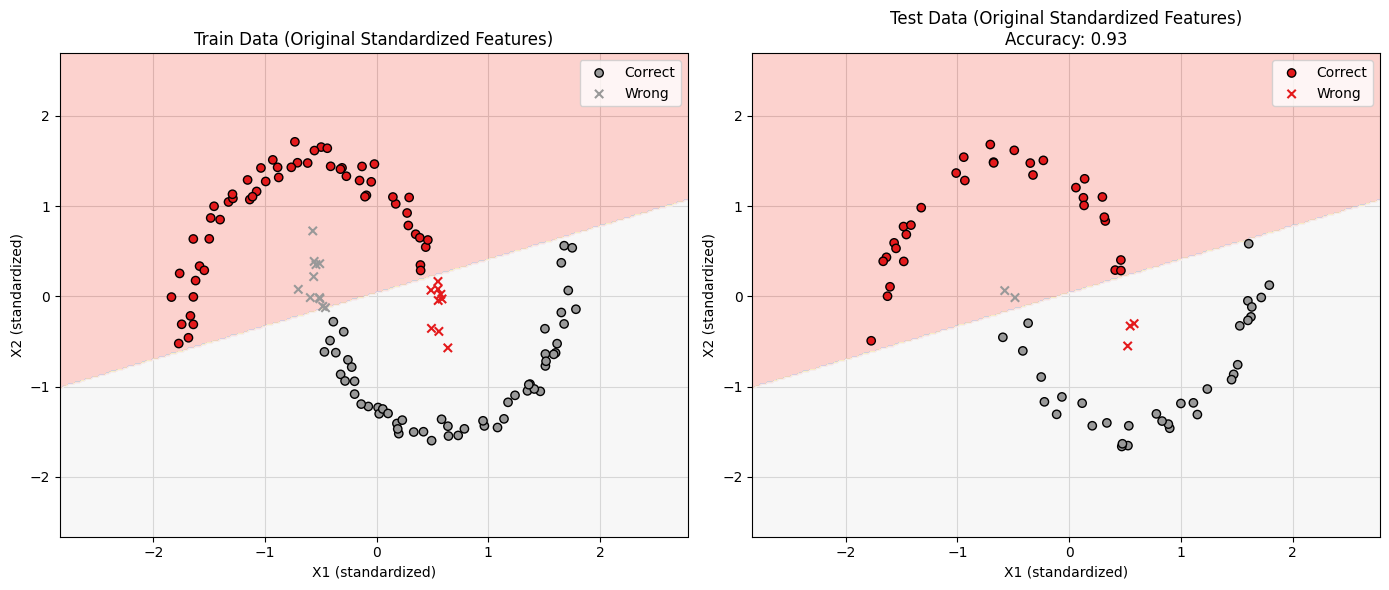

In [11]:
# Step 1: Create meshgrid in original (standardized) space
def create_meshgrid_orig(X, h=0.02):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy, np.c_[xx.ravel(), yy.ravel()]

# Prepare meshgrid using original standardized features
X_combined = np.vstack([df_train[["X1", "X2"]].values, df_test[["X1", "X2"]].values])
xx, yy, grid = create_meshgrid_orig(X_combined)
Z = clf_orig.predict(grid).reshape(xx.shape)

# Step 2: Prediction correctness masks
y_train = df_train["Label"].values
y_test = df_test["Label"].values

train_correct = y_train_pred_orig == y_train
train_wrong = ~train_correct
test_correct = y_test_pred_orig == y_test
test_wrong = ~test_correct

# Step 3: Plot
plt.figure(figsize=(14, 6))

# === TRAINING DATA ===
plt.subplot(1, 2, 1)
plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1, alpha=0.6)

plt.scatter(df_train.iloc[train_correct]["X1"], df_train.iloc[train_correct]["X2"],
            c=y_train[train_correct], cmap=plt.cm.Set1, edgecolor='k', label='Correct')
plt.scatter(df_train.iloc[train_wrong]["X1"], df_train.iloc[train_wrong]["X2"],
            c=y_train[train_wrong], cmap=plt.cm.Set1, edgecolor='k', marker='x', label='Wrong')

plt.title("Train Data (Original Standardized Features)")
plt.xlabel("X1 (standardized)")
plt.ylabel("X2 (standardized)")
plt.grid(True)
plt.legend()

# === TESTING DATA ===
plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1, alpha=0.6)

plt.scatter(df_test.iloc[test_correct]["X1"], df_test.iloc[test_correct]["X2"],
            c=y_test[test_correct], cmap=plt.cm.Set1, edgecolor='k', label='Correct')
plt.scatter(df_test.iloc[test_wrong]["X1"], df_test.iloc[test_wrong]["X2"],
            c=y_test[test_wrong], cmap=plt.cm.Set1, edgecolor='k', marker='x', label='Wrong')

plt.title(f"Test Data (Original Standardized Features)\nAccuracy: {test_accuracy_orig:.2f}")
plt.xlabel("X1 (standardized)")
plt.ylabel("X2 (standardized)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

As we will observe, due to the **inherently nonlinear shape** of the `make_moons` dataset, logistic regression struggles to accurately capture the curved decision boundary—resulting in visible misclassifications. This underscores the need for **nonlinear transformations**, which we will explore next using PCA and Kernel PCA.

### Introducing PCA

At first glance, the two features in our dataset—though standardized—might not be the most informative directions to describe the class structure. What if we could rotate our coordinate system to **capture the most variation** in the data using new axes? That’s exactly what PCA allows us to do.

PCA helps us **reorient the feature space** to align with directions where the data varies the most. These directions, called **principal components**, are uncorrelated and ordered by how much information (variance) they retain.

By projecting our data onto these new axes, we gain two key insights:
- How much of the original data’s structure can be captured linearly.
- Whether logistic regression performs any better when trained on these optimized projections.

Before diving into classification again, we’ll fit PCA to the training data, visualize the new axes, and examine how well they represent the original feature space. This sets the stage for a fairer comparison between PCA, Kernel PCA, and the raw features.


Principal Component Directions (unit vectors):
PC1: [-0.70134542  0.71282158]
PC2: [0.71282158 0.70134542]

Explained Variance Ratio:
[0.71930335 0.28069665]


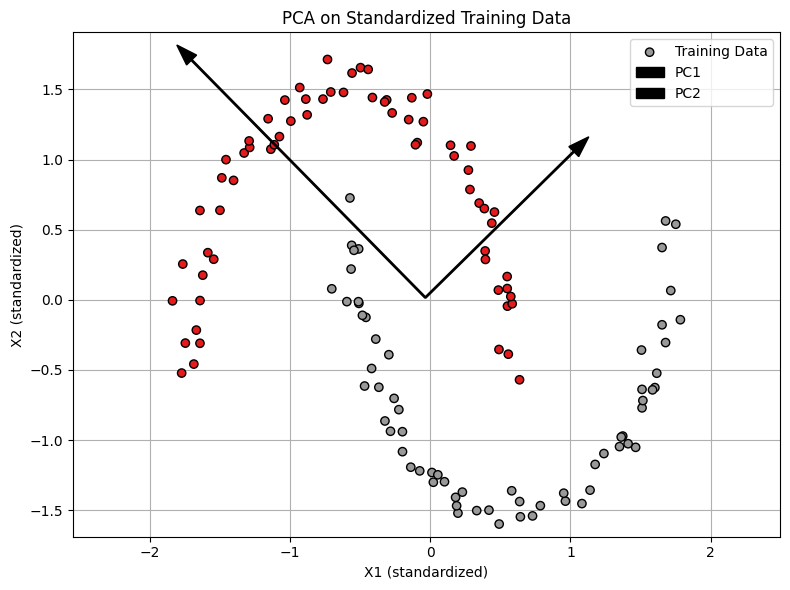

In [12]:
# Step 1: Fit PCA on training data (standardized)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(df_train[["X1", "X2"]])
X_test_pca = pca.transform(df_test[["X1", "X2"]])

# Step 2: Extract PCA components and mean
components = pca.components_  # shape (2, 2)
mean = pca.mean_

# Step 3: Print PCA info
print("Principal Component Directions (unit vectors):")
print("PC1:", components[0])
print("PC2:", components[1])
print("\nExplained Variance Ratio:")
print(pca.explained_variance_ratio_)

# Step 4: Plot
plt.figure(figsize=(8, 6))
plt.scatter(df_train["X1"], df_train["X2"], c=df_train["Label"], cmap=plt.cm.Set1, edgecolor='k', label='Training Data')

# Draw PCA arrows
for i, vector in enumerate(components):
    arrow = vector * 2 * np.sqrt(pca.explained_variance_[i])
    plt.arrow(mean[0], mean[1], arrow[0], arrow[1], color='black', width=0.01, head_width=0.1, label=f'PC{i+1}')

plt.title("PCA on Standardized Training Data")
plt.xlabel("X1 (standardized)")
plt.ylabel("X2 (standardized)")
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Visualizing Data Projections onto Principal Components

Next, we project the full dataset onto each principal component separately to **see how the data aligns with the directions of maximum variance**. The dashed lines show the orthogonal projection from each point to the selected component, helping us build intuition about what PCA captures.


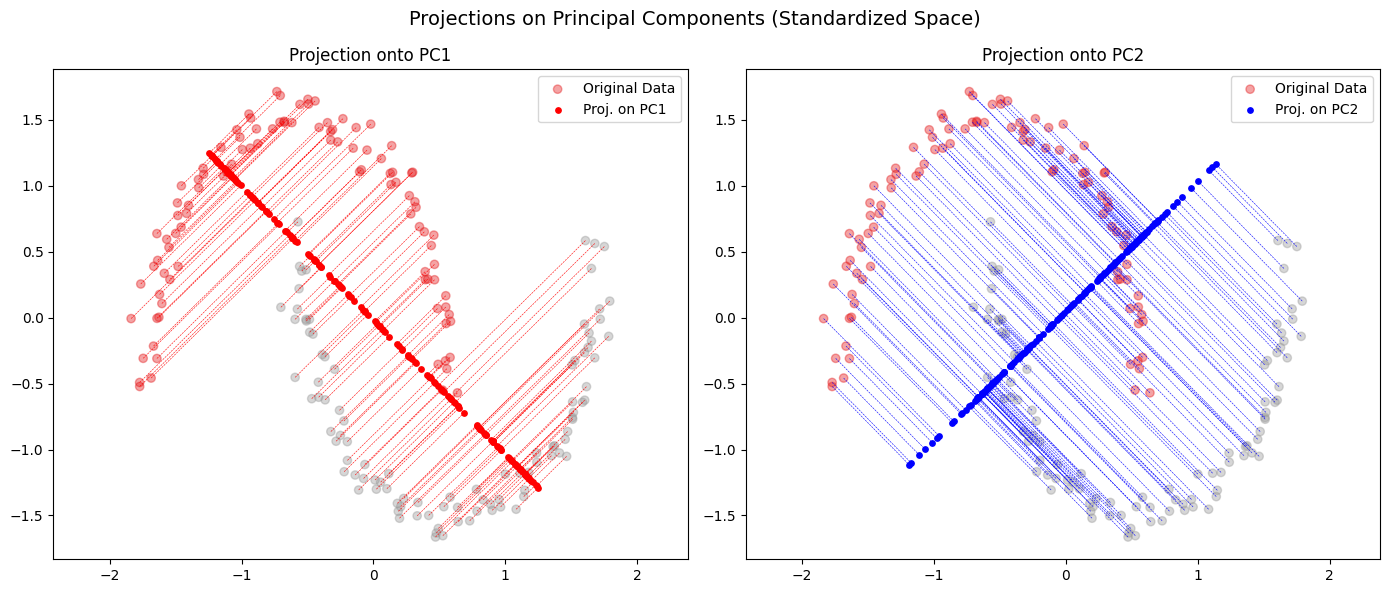

In [13]:
# Use standardized full data for projection
X = df_scaled[["X1", "X2"]].values
labels = df["Label"].values

# Reuse PCA components and mean from previous training
components = pca.components_
mean = pca.mean_

# Center the data
X_centered = X - mean

# Project onto PC1 and PC2 directions
proj_pc1 = np.outer(X_centered @ components[0], components[0]) + mean
proj_pc2 = np.outer(X_centered @ components[1], components[1]) + mean

# Plot projections
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# PC1 projection
axs[0].scatter(X[:, 0], X[:, 1], c=labels, cmap=plt.cm.Set1, alpha=0.4, label='Original Data')
axs[0].scatter(proj_pc1[:, 0], proj_pc1[:, 1], c='red', s=15, label='Proj. on PC1')
for i in range(len(X)):
    axs[0].plot([X[i, 0], proj_pc1[i, 0]], [X[i, 1], proj_pc1[i, 1]], 'r--', linewidth=0.4)
axs[0].set_title("Projection onto PC1")
axs[0].axis("equal")
axs[0].legend()

# PC2 projection
axs[1].scatter(X[:, 0], X[:, 1], c=labels, cmap=plt.cm.Set1, alpha=0.4, label='Original Data')
axs[1].scatter(proj_pc2[:, 0], proj_pc2[:, 1], c='blue', s=15, label='Proj. on PC2')
for i in range(len(X)):
    axs[1].plot([X[i, 0], proj_pc2[i, 0]], [X[i, 1], proj_pc2[i, 1]], 'b--', linewidth=0.4)
axs[1].set_title("Projection onto PC2")
axs[1].axis("equal")
axs[1].legend()

plt.suptitle("Projections on Principal Components (Standardized Space)", fontsize=14)
plt.tight_layout()
plt.show()

### Logistic Regression in PCA Space

After transforming the data using PCA, we train a new logistic regression model in this reduced coordinate system. By aligning the features along directions of maximum variance, PCA may help the model focus on the most informative structure—though it still assumes linear separability. We evaluate its predictions on both the training and test sets to see if this reorientation improves classification performance.


In [14]:
# Step 1: Train logistic regression on PCA-transformed training data
clf_pca = LogisticRegression()
clf_pca.fit(X_train_pca, df_train["Label"])

# Step 2: Predict on both train and test data
y_train_pred = clf_pca.predict(X_train_pca)
y_test_pred = clf_pca.predict(X_test_pca)

# Step 3: Compute test accuracy
test_accuracy = accuracy_score(df_test["Label"], y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")


Test Accuracy: 0.93


### Why Didn’t PCA Improve Accuracy?

Even after transforming the data using PCA, we observe that the test accuracy of logistic regression remains **unchanged**. This is expected because **PCA is a linear technique**—it simply rotates the coordinate axes to align with directions of maximum variance, but it **does not change the inherent structure** of the data.

Since the `make_moons` dataset has a **nonlinear class boundary**, projecting the data into a different linear basis (via PCA) doesn’t help a linear classifier like logistic regression overcome the fundamental limitation. This highlights the need for **nonlinear transformations** that can better capture the underlying geometry of the data—motivating our next step: **Kernel PCA**.


### Visualizing Decision Boundary in PCA Space

We would like to visualize how logistic regression separates the classes after PCA transformation. To visualize decision boundaries, we create meshgrids to contast the classes and plot predictions and their correctness on top of it.

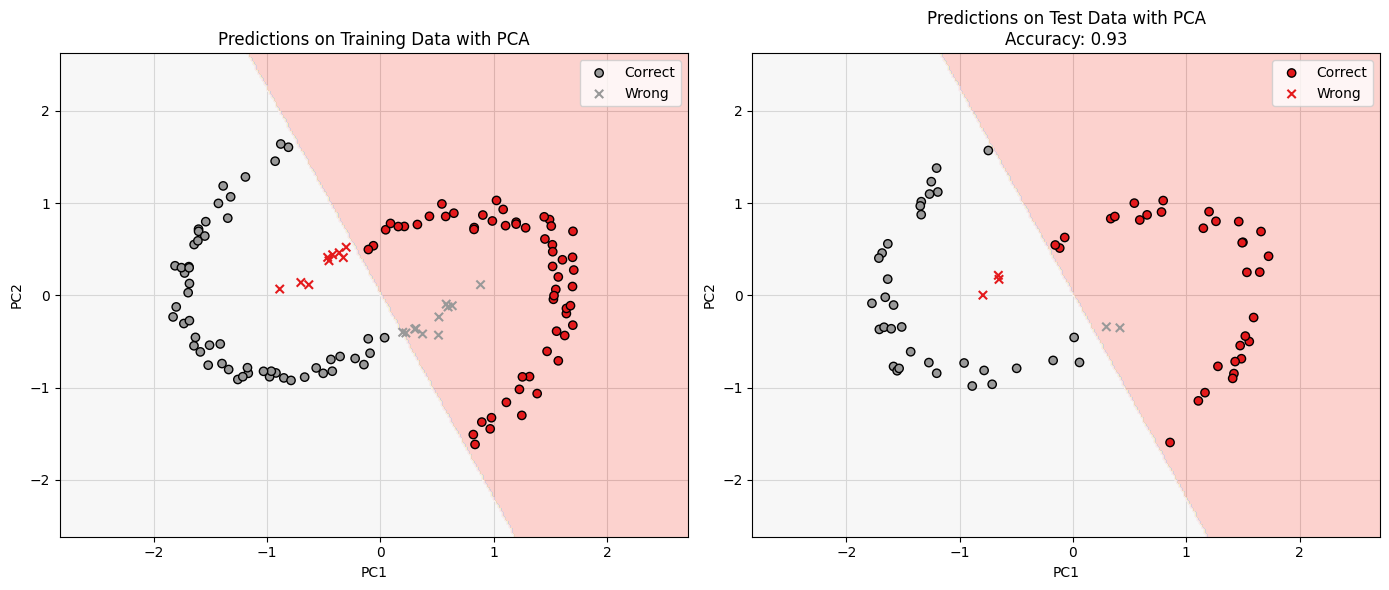

In [15]:
# Helper: create meshgrid over PCA space
def create_meshgrid(X, h=0.02):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy, np.c_[xx.ravel(), yy.ravel()]

# Create mesh and get predictions over the grid
xx, yy, grid = create_meshgrid(np.vstack([X_train_pca, X_test_pca]))
Z = clf_pca.predict(grid).reshape(xx.shape)

# Labels
y_train = df_train["Label"].values
y_test = df_test["Label"].values

# Prediction correctness masks
train_correct = y_train_pred == y_train
train_wrong = ~train_correct
test_correct = y_test_pred == y_test
test_wrong = ~test_correct

# Plotting
plt.figure(figsize=(14, 6))

# === TRAINING DATA ===
plt.subplot(1, 2, 1)
plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1, alpha=0.6)

plt.scatter(X_train_pca[train_correct, 0], X_train_pca[train_correct, 1],
            c=y_train[train_correct], cmap=plt.cm.Set1, edgecolor='k', label='Correct')
plt.scatter(X_train_pca[train_wrong, 0], X_train_pca[train_wrong, 1],
            c=y_train[train_wrong], cmap=plt.cm.Set1, edgecolor='k', marker='x', label='Wrong')

plt.title("Predictions on Training Data with PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)

# === TESTING DATA ===
plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1, alpha=0.6)

plt.scatter(X_test_pca[test_correct, 0], X_test_pca[test_correct, 1],
            c=y_test[test_correct], cmap=plt.cm.Set1, edgecolor='k', label='Correct')
plt.scatter(X_test_pca[test_wrong, 0], X_test_pca[test_wrong, 1],
            c=y_test[test_wrong], cmap=plt.cm.Set1, edgecolor='k', marker='x', label='Wrong')

plt.title(f"Predictions on Test Data with PCA\nAccuracy: {test_accuracy:.2f}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Mapping PCA Decision Boundary Back to Original Space

When we visualize predictions in PCA space, the plot may appear **rotated or skewed**. This is because PCA redefines the coordinate system based on directions of maximum variance, so the axes no longer align with the original features (`X1`, `X2`).

To interpret the decision boundary **in the context of the original feature space**, we need to **invert the PCA transformation**. This step maps the meshgrid (used for classification visualization) back into the standardized coordinate system, allowing us to see how the linear boundary in PCA space corresponds to the curved structure of the original data.

This final visualization helps bridge intuition between the PCA-transformed space and the real-world structure of our input features.


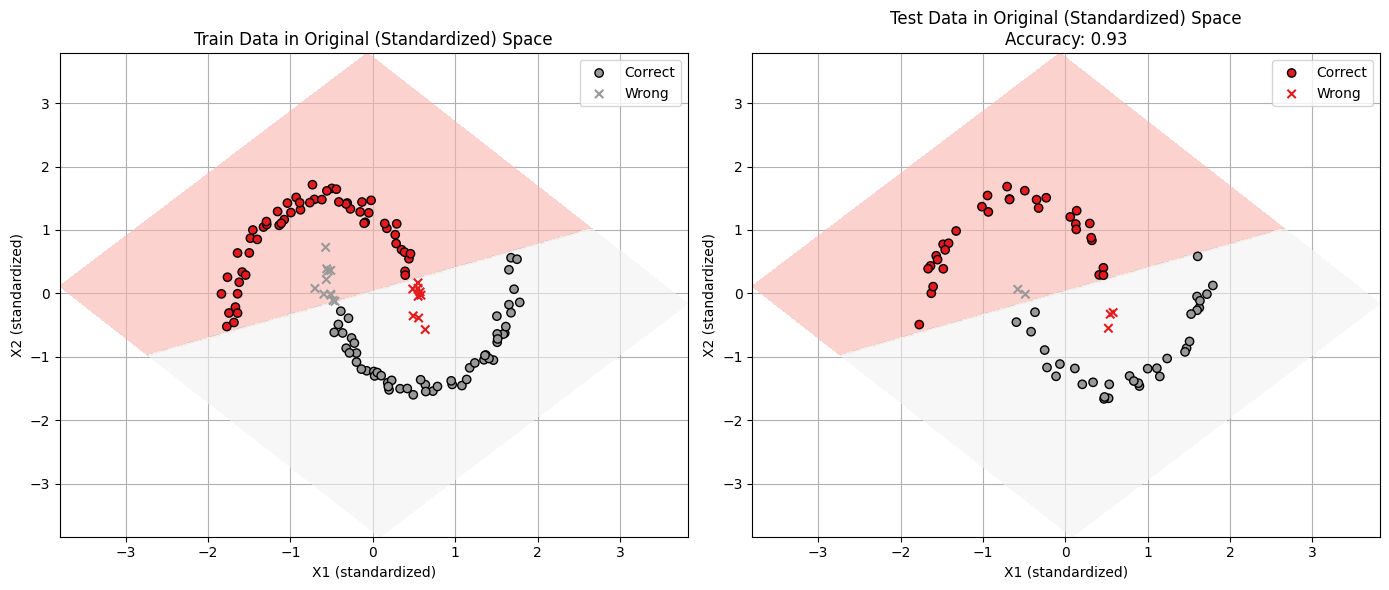

In [16]:
# Step 1: Create meshgrid in PCA space
xx_pca, yy_pca, grid_pca = create_meshgrid(np.vstack([X_train_pca, X_test_pca]))
Z = clf_pca.predict(grid_pca).reshape(xx_pca.shape)

# Step 2: Inverse transform meshgrid back to standardized space
grid_orig = pca.inverse_transform(grid_pca)
xx_orig = grid_orig[:, 0].reshape(xx_pca.shape)
yy_orig = grid_orig[:, 1].reshape(yy_pca.shape)

# Step 3: Prepare prediction correctness masks
y_train = df_train["Label"].values
y_test = df_test["Label"].values

train_correct = y_train_pred == y_train
train_wrong = ~train_correct
test_correct = y_test_pred == y_test
test_wrong = ~test_correct

# Step 4: Plot
plt.figure(figsize=(14, 6))

# === TRAINING DATA ===
plt.subplot(1, 2, 1)
plt.contourf(xx_orig, yy_orig, Z, cmap=plt.cm.Pastel1, alpha=0.6)

plt.scatter(df_train.iloc[train_correct]["X1"], df_train.iloc[train_correct]["X2"],
            c=y_train[train_correct], cmap=plt.cm.Set1, edgecolor='k', label='Correct')
plt.scatter(df_train.iloc[train_wrong]["X1"], df_train.iloc[train_wrong]["X2"],
            c=y_train[train_wrong], cmap=plt.cm.Set1, edgecolor='k', marker='x', label='Wrong')

plt.title("Train Data in Original (Standardized) Space")
plt.xlabel("X1 (standardized)")
plt.ylabel("X2 (standardized)")
plt.grid(True)
plt.legend()

# === TESTING DATA ===
plt.subplot(1, 2, 2)
plt.contourf(xx_orig, yy_orig, Z, cmap=plt.cm.Pastel1, alpha=0.6)

plt.scatter(df_test.iloc[test_correct]["X1"], df_test.iloc[test_correct]["X2"],
            c=y_test[test_correct], cmap=plt.cm.Set1, edgecolor='k', label='Correct')
plt.scatter(df_test.iloc[test_wrong]["X1"], df_test.iloc[test_wrong]["X2"],
            c=y_test[test_wrong], cmap=plt.cm.Set1, edgecolor='k', marker='x', label='Wrong')

plt.title(f"Test Data in Original (Standardized) Space\nAccuracy: {test_accuracy:.2f}")
plt.xlabel("X1 (standardized)")
plt.ylabel("X2 (standardized)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Despite PCA reorienting the data along axes of maximum variance, the decision boundary remains **linear** in this transformed space, which still fails to capture the **inherent nonlinearity** of the original dataset. This further emphasizes the need for a nonlinear projection, which we will explore next using **Kernel PCA**.

### Kernel PCA

So far, we’ve used **standard PCA** to transform our data before applying logistic regression. While PCA successfully reorients the feature space to capture maximum variance, it still relies on **linear assumptions**—which limits its ability to reveal nonlinear structures in the data.

In datasets like `make_moons`, where the classes are arranged in curved, interleaved patterns, linear projections (like PCA) **cannot effectively untangle the structure**. As a result, linear models such as logistic regression **struggle to separate the classes**, even after PCA transformation.

This brings us to the need for a non-linear tool: **Kernel Principal Component Analysis (Kernel PCA)**.

---

### What is Kernel PCA?

**Kernel PCA** is an extension of PCA that enables **nonlinear dimensionality reduction**. The key idea is to **map the data into a higher-dimensional feature space** where linear separability becomes possible, and then perform PCA in that space.

But instead of computing this mapping explicitly (which may be computationally expensive or infinite-dimensional), we use the **kernel trick**. A **kernel function** computes dot products in the higher-dimensional space without ever needing to compute the transformation directly.


- Standard PCA involves computing the covariance matrix of data `X` and solving for eigenvectors.

- In Kernel PCA, we use a **kernel matrix** `K`, where each entry `K[i, j] = k(x_i, x_j)` is the similarity between points `x_i` and `x_j`.

- The kernel function acts like a shortcut to perform PCA in a **nonlinear feature space**, using only dot products.

- After centering the kernel matrix, we solve an eigenvalue problem:  
  → `K_centered * alpha = lambda * alpha`  
  where `alpha` contains the principal components in the kernel space.

- The transformed (projected) data is then:  
  → `z_i = sum_j alpha_j * k(x_i, x_j)`

This gives a new representation of each point based on nonlinear relationships to all others.

---

 Common Kernel Functions

- **RBF (Gaussian)**:  
  `k(x, y) = exp(-γ * ||x - y||²)`

- **Polynomial**:  
  `k(x, y) = (x ⋅ y + c)^d`

- **Sigmoid**:  
  `k(x, y) = tanh(κ * x ⋅ y + θ)`

In this notebook, we’ll use the **RBF kernel**, which is ideal for uncovering **local, curved structures** — perfect for the `make_moons` dataset.

---

### Advantages of Kernel PCA

- **Captures Nonlinear Relationships**: Unlike linear PCA, Kernel PCA can reveal complex manifolds and class structures in the data.
- **Flexible with Choice of Kernel**: By choosing an appropriate kernel function (e.g., RBF), we can tailor the transformation to fit the problem.
- **Improves Linearly Separable Representations**: It can transform data into a space where even simple classifiers like logistic regression or linear SVMs can perform well.
- **Unsupervised**: Like PCA, Kernel PCA does not rely on label information—making it broadly applicable for preprocessing and visualization.

---

Next, we’ll apply Kernel PCA to the `make_moons` dataset and see how it **transforms the data into a space where linear models can succeed**.


### Applying Kernel PCA with Initial Gamma Guess

We now apply **Kernel PCA** using an **RBF (Radial Basis Function)** kernel. This kernel introduces a key hyperparameter: **`gamma`**, which controls the **flexibility** of the transformation.

The `gamma` parameter determines how far the influence of a single training example reaches:
- A **small gamma** value (e.g., `0.1`) results in a **smoother, more global** transformation — it captures large-scale structure.
- A **large gamma** (e.g., `10` or higher) makes the transformation more **localized and sensitive** to individual data points — capturing finer patterns but also risking overfitting.

In this step, we set `gamma = 10` as an **initial guess**, without tuning. While this value may capture some nonlinear patterns, we **should not expect optimal performance**. Without tuning gamma through techniques like cross-validation, we risk underfitting or overfitting the transformed data.


In [17]:
# Step 1: Apply Kernel PCA to full standardized dataset
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=10, fit_inverse_transform=False)
X_kpca = kpca.fit_transform(df_scaled[["X1", "X2"]])
X_train_kpca = kpca.transform(df_train[["X1", "X2"]])
X_test_kpca = kpca.transform(df_test[["X1", "X2"]])

# Step 2: Train logistic regression on kernel PCA-transformed features
clf_kpca = LogisticRegression()
clf_kpca.fit(X_train_kpca, df_train["Label"])

# Step 3: Predict and evaluate
y_train_pred_kpca = clf_kpca.predict(X_train_kpca)
y_test_pred_kpca = clf_kpca.predict(X_test_kpca)

test_accuracy_kpca = accuracy_score(df_test["Label"], y_test_pred_kpca)
print(f"Kernel PCA Test Accuracy: {test_accuracy_kpca:.2f}")

Kernel PCA Test Accuracy: 0.91


### Tuning the Gamma Parameter in Kernel PCA

As we’ve seen, the `gamma` parameter in the RBF kernel plays a crucial role in controlling the shape of the nonlinear transformation in Kernel PCA. However, there is **no universally optimal value** for gamma—it must be **tuned based on the dataset**.

To do this, we explore a **range of gamma values** and evaluate model performance using logistic regression on Kernel PCA-transformed features. Rather than trying values linearly spaced (e.g., 1, 2, 3...), we use a **logarithmic scale** to span several orders of magnitude:

This is done using `np.logspace(-2, 2, 100)`, which creates 100 values between (0.01) and (100). This approach is preferred because gamma affects the transformation **exponentially**—small changes in low ranges have a very different impact than small changes in high ranges.

For each candidate gamma:
1. We fit **Kernel PCA** with that gamma.
2. We transform the training and test sets.
3. We train **logistic regression** and compute the **test accuracy**.

By recording accuracy for each gamma, we identify the value that gives the **best performance** on the test set. This tuned gamma will give us a **well-balanced transformation**—not too rigid, not too smooth—and enable logistic regression to achieve optimal classification accuracy in the transformed space.



In [18]:
# Grid of gamma values to try
gamma_list = np.logspace(-2, 2, 100)  # from 0.01 to 100 (log scale)
accuracy_scores = []

for gamma in gamma_list:
    # Step 1: Fit Kernel PCA on training part
    kpca_tune = KernelPCA(n_components=2, kernel='rbf', gamma=gamma)
    X_kpca_tune = kpca_tune.fit_transform(df_scaled[["X1", "X2"]])
    X_train_kpca_tune = kpca_tune.transform(df_train[["X1", "X2"]])
    X_test_kpca_tune = kpca_tune.transform(df_test[["X1", "X2"]])

    # Step 2: Fit logistic regression
    clf = LogisticRegression()
    clf.fit(X_train_kpca_tune, df_train["Label"])

    # Step 3: Predict on validation set
    y_val_pred = clf.predict(X_test_kpca_tune)
    acc = accuracy_score(df_test["Label"], y_val_pred)
    accuracy_scores.append(acc)

    #print(f"Gamma: {gamma:.4f}, Validation Accuracy: {acc:.4f}")

# Best gamma
best_gamma = gamma_list[np.argmax(accuracy_scores)]
print(f"\n Best gamma: {best_gamma:.4f} with accuracy: {max(accuracy_scores):.4f}")
np.argmax(accuracy_scores)


 Best gamma: 14.1747 with accuracy: 0.9857


np.int64(78)

### Final Model: Logistic Regression with Tuned Kernel PCA

Using the **best gamma value** found from our tuning process (`gamma ≈ 14.17`), we now retrain Kernel PCA on the full dataset and fit a logistic regression model on the transformed features.

This final setup gives us a well-balanced nonlinear transformation that effectively **unfolds the curved structure** of the `make_moons` data, allowing logistic regression to perform with **significantly improved accuracy**. The results below show both training and test accuracy using this optimized configuration.

In [19]:
# === Use the best gamma found from tuning ===
best_gamma = 14.1747  # Replace this with the actual value from tuning

# Step 1: Fit Kernel PCA on the full training set
kpca_final = KernelPCA(n_components=2, kernel='rbf', gamma=best_gamma)
X_kpca = kpca_final.fit_transform(df_scaled[["X1", "X2"]])
X_train_kpca = kpca_final.transform(df_train[["X1", "X2"]])
X_test_kpca = kpca_final.transform(df_test[["X1", "X2"]])

# Step 2: Train logistic regression on KPCA-transformed training data
clf_kpca_final = LogisticRegression()
clf_kpca_final.fit(X_train_kpca, df_train["Label"])

# Step 3: Predict and evaluate
y_train_pred_final = clf_kpca_final.predict(X_train_kpca)
y_test_pred_final = clf_kpca_final.predict(X_test_kpca)

train_acc = accuracy_score(df_train["Label"], y_train_pred_final)
test_acc = accuracy_score(df_test["Label"], y_test_pred_final)

# Step 4: Display results
print(f"Final Logistic Regression on Kernel PCA Features")
print(f"Gamma used: {best_gamma}")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Final Logistic Regression on Kernel PCA Features
Gamma used: 14.1747
Train Accuracy: 0.9154
Test Accuracy: 0.9857


### Decision Boundary in Kernel PCA Space

Next, we would like to how the logistic regression model classifies points after transforming the data using **Kernel PCA with the tuned gamma**. The background colors represent the predicted class regions, and the scatter points show correctly and incorrectly classified samples.

The **nonlinear shape** of the decision boundary—often warped or oddly contoured—is expected. Unlike PCA, Kernel PCA transforms the data into a new space based on **similarity to other points**, not along fixed directions of variance. As a result, the axes (KPC1, KPC2) **don’t have intuitive geometric interpretations**, and the transformed data can curve or twist in ways that **make linear classification possible**—but hard to visualize naturally.


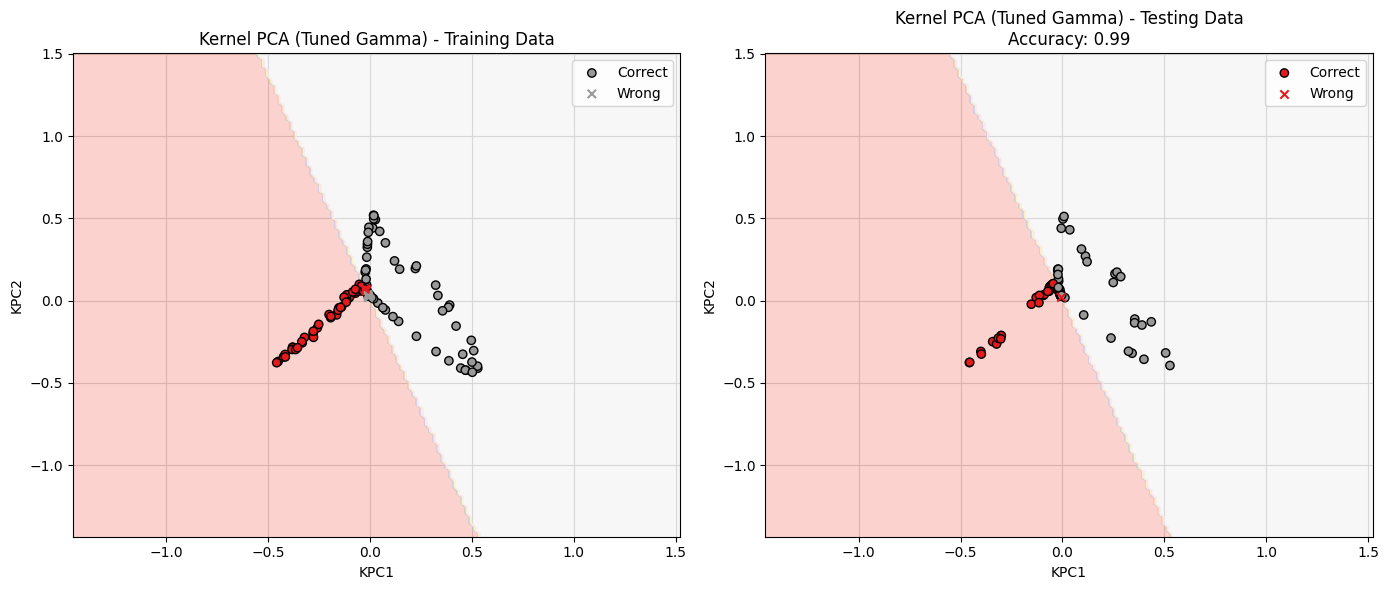

In [20]:
# Step 1: Create meshgrid in Kernel PCA space
xx, yy, grid = create_meshgrid(np.vstack([X_train_kpca, X_test_kpca]))
Z = clf_kpca_final.predict(grid).reshape(xx.shape)

# Step 2: Prepare labels
y_train = df_train["Label"].values
y_test = df_test["Label"].values

train_correct = y_train_pred_final == y_train
train_wrong = ~train_correct
test_correct = y_test_pred_final == y_test
test_wrong = ~test_correct

# Step 3: Plotting
plt.figure(figsize=(14, 6))

# === TRAINING DATA ===
plt.subplot(1, 2, 1)
plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1, alpha=0.6)

plt.scatter(X_train_kpca[train_correct, 0], X_train_kpca[train_correct, 1],
            c=y_train[train_correct], cmap=plt.cm.Set1, edgecolor='k', label='Correct')
plt.scatter(X_train_kpca[train_wrong, 0], X_train_kpca[train_wrong, 1],
            c=y_train[train_wrong], cmap=plt.cm.Set1, edgecolor='k', marker='x', label='Wrong')

plt.title("Kernel PCA (Tuned Gamma) - Training Data")
plt.xlabel("KPC1")
plt.ylabel("KPC2")
plt.legend()
plt.grid(True)

# === TESTING DATA ===
plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1, alpha=0.6)

plt.scatter(X_test_kpca[test_correct, 0], X_test_kpca[test_correct, 1],
            c=y_test[test_correct], cmap=plt.cm.Set1, edgecolor='k', label='Correct')
plt.scatter(X_test_kpca[test_wrong, 0], X_test_kpca[test_wrong, 1],
            c=y_test[test_wrong], cmap=plt.cm.Set1, edgecolor='k', marker='x', label='Wrong')

plt.title(f"Kernel PCA (Tuned Gamma) - Testing Data\nAccuracy: {test_acc:.2f}")
plt.xlabel("KPC1")
plt.ylabel("KPC2")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Visualizing Kernel PCA Decision Boundary in Original Feature Space

Unlike linear PCA, **Kernel PCA is a one-way transformation**. Since it relies on a **nonlinear, implicit mapping** to a high-dimensional feature space, there is **no straightforward inverse transform** that brings the data back to the original space. This is because the mapping function φ(x) is never explicitly known—only the dot products between pairs of points are computed via a kernel function.

So how can we visualize a classifier trained in this transformed space?

We use a **clever workaround**: instead of trying to invert the transformation, we do the reverse.  
1. We create a **meshgrid in the original (standardized) feature space**.
2. We **transform this grid into the Kernel PCA space** using the trained KPCA model.
3. We **make predictions** in the transformed space using our logistic regression classifier.
4. We then **plot the predictions on the original grid**, creating a contour map of the decision regions.

This trick allows us to visualize the classifier's decision boundary **in the original space**, even though all modeling happens in the nonlinear transformed space.

However, there’s a caveat:  
Since Kernel PCA only retains a **limited number of principal components** (in our case, two), the transformation is effectively a **low-dimensional slice of the full, infinite-dimensional space**. As a result, the visualization captures only an approximation of the actual decision boundary. It’s still incredibly insightful—but constrained by the number of components used.

This approach offers the best of both worlds: the **nonlinear separation power** of Kernel PCA and the **interpretability of visualization** in the original feature space.


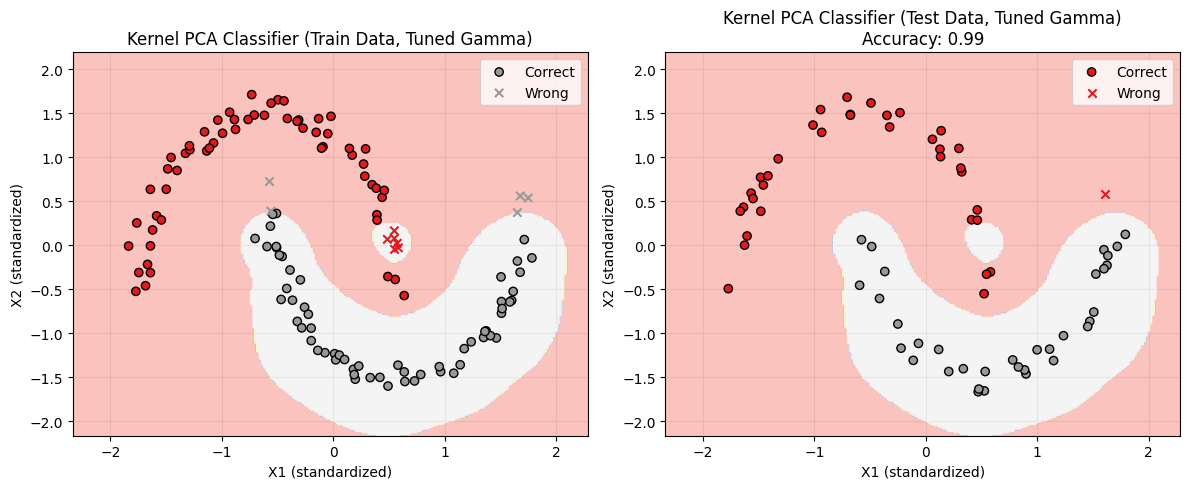

In [21]:
# Step 1: Create a meshgrid in original (standardized) input space
h = 0.02
X_std = df_scaled[["X1", "X2"]].values  # standardized full dataset
x_min, x_max = X_std[:, 0].min() - 0.5, X_std[:, 0].max() + 0.5
y_min, y_max = X_std[:, 1].min() - 0.5, X_std[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]

# Step 2: Project grid to KPCA space and predict
grid_kpca = kpca_final.transform(grid)
Z = clf_kpca_final.predict(grid_kpca).reshape(xx.shape)

# Step 3: Prep labels
y_train = df_train["Label"].values
y_test = df_test["Label"].values

# Step 4: Train and test prediction masks (final predictions)
train_wrong = y_train_pred_final != y_train
train_correct = ~train_wrong
test_wrong = y_test_pred_final != y_test
test_correct = ~test_wrong

# Standardized features
X_train = df_train[["X1", "X2"]].values
X_test = df_test[["X1", "X2"]].values

# === TRAIN PLOT ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1, alpha=0.8)

plt.scatter(X_train[train_correct, 0], X_train[train_correct, 1],
            c=y_train[train_correct], cmap=plt.cm.Set1, edgecolor='k', label='Correct')
plt.scatter(X_train[train_wrong, 0], X_train[train_wrong, 1],
            c=y_train[train_wrong], cmap=plt.cm.Set1, edgecolor='k', marker='x', label='Wrong')

plt.title("Kernel PCA Classifier (Train Data, Tuned Gamma)")
plt.xlabel("X1 (standardized)")
plt.ylabel("X2 (standardized)")
plt.legend()
plt.grid(True)

# === TEST PLOT ===
plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1, alpha=0.8)

plt.scatter(X_test[test_correct, 0], X_test[test_correct, 1],
            c=y_test[test_correct], cmap=plt.cm.Set1, edgecolor='k', label='Correct')
plt.scatter(X_test[test_wrong, 0], X_test[test_wrong, 1],
            c=y_test[test_wrong], cmap=plt.cm.Set1, edgecolor='k', marker='x', label='Wrong')

plt.title(f"Kernel PCA Classifier (Test Data, Tuned Gamma)\nAccuracy: {test_acc:.2f}")
plt.xlabel("X1 (standardized)")
plt.ylabel("X2 (standardized)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Dimensionality Reduction with PCA

Until now, we've been using both principal components from PCA—which means no actual reduction in dimensionality compared to the original 2D space. To unlock PCA's true potential, we now restrict our model to use **only the first principal component (PC1)**, reducing the data to **1D**.

PC1 captures the **maximum linear variance** in the dataset, and this test reveals how much of the class structure can be preserved and separated along just this single axis.

We train logistic regression on the **1D PCA-transformed data** and evaluate its classification performance. While we expect some drop in accuracy due to loss of information, this helps us:
- Understand the **efficiency of PCA** in capturing class structure with minimal dimensions.
- Compare it directly to **Kernel PCA**, which can achieve nonlinear separation even in 2D by leveraging richer transformations.

This forms a valuable baseline for assessing the potential of Kernel-PCA for dimensionality reduction.


In [22]:
# Step 1: Use only the first principal component (PC1)
X_train_pc1 = X_train_pca[:, [0]]  # shape (n_samples, 1)
X_test_pc1 = X_test_pca[:, [0]]    # same for test set

# Step 2: Train logistic regression on PC1
clf_pc1 = LogisticRegression()
clf_pc1.fit(X_train_pc1, df_train["Label"])

# Step 3: Predict and evaluate
y_train_pred_pc1 = clf_pc1.predict(X_train_pc1)
y_test_pred_pc1 = clf_pc1.predict(X_test_pc1)

test_accuracy_pc1 = accuracy_score(df_test["Label"], y_test_pred_pc1)
print(f"Test Accuracy (using only PC1): {test_accuracy_pc1:.2f}")


Test Accuracy (using only PC1): 0.87


### Classification Using Only PC1

This plot shows how logistic regression performs using just the **first principal component (PC1)**. By reducing the data to 1D, we can visualize the **decision boundary** and how well the model separates classes along this axis. Correct and incorrect predictions are shown for both training and test sets, helping us assess the effectiveness of this dimensionality reduction.


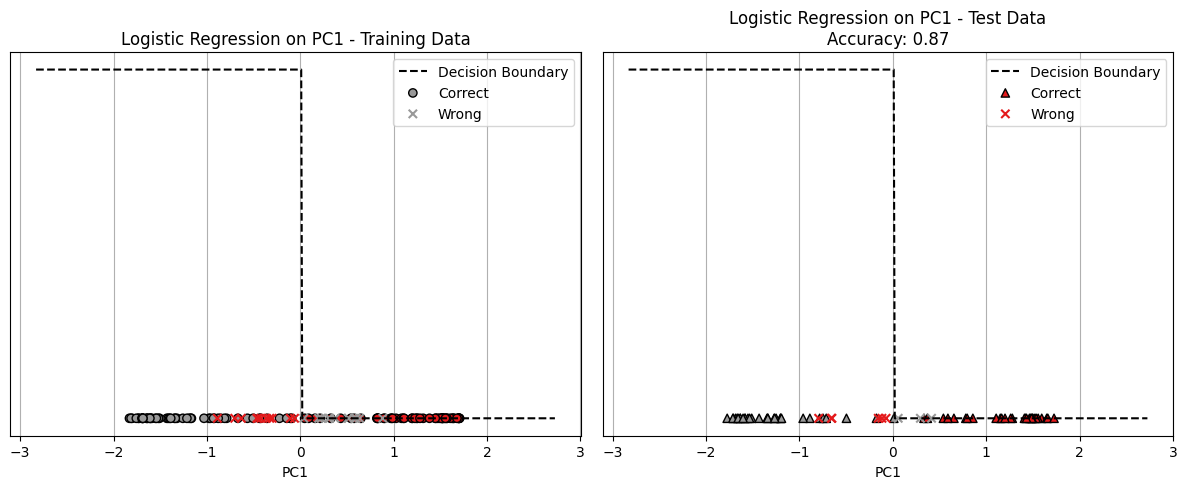

In [23]:
# Combine for consistent axis
X_combined_pc1 = np.vstack([X_train_pc1, X_test_pc1])
x_min, x_max = X_combined_pc1.min() - 1, X_combined_pc1.max() + 1
x_vals = np.linspace(x_min, x_max, 500).reshape(-1, 1)
y_vals = clf_pc1.predict(x_vals)

# Masks for correctness
train_correct = y_train_pred_pc1 == df_train["Label"].values
train_wrong = ~train_correct
test_correct = y_test_pred_pc1 == df_test["Label"].values
test_wrong = ~test_correct

plt.figure(figsize=(12, 5))

# === TRAINING DATA ===
plt.subplot(1, 2, 1)
plt.plot(x_vals, y_vals, color='black', linestyle='--', label='Decision Boundary')
plt.scatter(X_train_pc1[train_correct], np.zeros_like(X_train_pc1[train_correct]),
            c=df_train["Label"].values[train_correct], cmap=plt.cm.Set1,
            edgecolor='k', label='Correct')
plt.scatter(X_train_pc1[train_wrong], np.zeros_like(X_train_pc1[train_wrong]),
            c=df_train["Label"].values[train_wrong], cmap=plt.cm.Set1,
            edgecolor='k', marker='x', label='Wrong')
plt.title("Logistic Regression on PC1 - Training Data")
plt.xlabel("PC1")
plt.yticks([])
plt.grid(True)
plt.legend()

# === TESTING DATA ===
plt.subplot(1, 2, 2)
plt.plot(x_vals, y_vals, color='black', linestyle='--', label='Decision Boundary')
plt.scatter(X_test_pc1[test_correct], np.zeros_like(X_test_pc1[test_correct]),
            c=df_test["Label"].values[test_correct], cmap=plt.cm.Set1,
            edgecolor='k', marker='^', label='Correct')
plt.scatter(X_test_pc1[test_wrong], np.zeros_like(X_test_pc1[test_wrong]),
            c=df_test["Label"].values[test_wrong], cmap=plt.cm.Set1,
            edgecolor='k', marker='x', label='Wrong')
plt.title(f"Logistic Regression on PC1 - Test Data\nAccuracy: {test_accuracy_pc1:.2f}")
plt.xlabel("PC1")
plt.yticks([])
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### Visualizing PC1-Based Classification in Original Space

Although our model uses only **PC1** (a 1D projection), we can still visualize its decision boundary in the **original 2D space**. To do this, we project a meshgrid from the input space onto PC1, make predictions, and map them back to show the classification regions. This helps illustrate how a **1D decision rule** slices through the 2D feature space and where it struggles to separate classes.


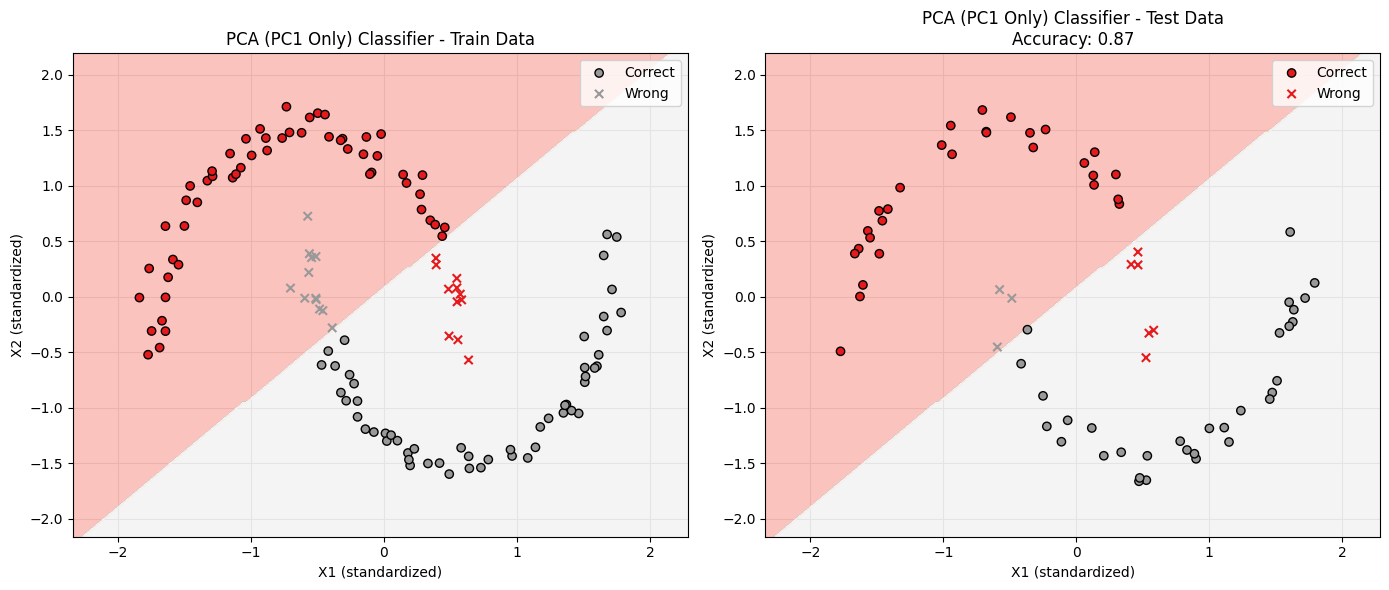

In [24]:
# Step 1: Create 2D meshgrid in original (standardized) input space
h = 0.02
X_std = df_scaled[["X1", "X2"]].values
x_min, x_max = X_std[:, 0].min() - 0.5, X_std[:, 0].max() + 0.5
y_min, y_max = X_std[:, 1].min() - 0.5, X_std[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]

# Step 2: Project meshgrid to PCA space, keep only PC1
grid_pca_2d = pca.transform(grid)         # shape: (N, 2)
grid_pc1_only = grid_pca_2d[:, [0]]       # shape: (N, 1)
Z = clf_pc1.predict(grid_pc1_only).reshape(xx.shape)

# Step 3: Correctness masks
y_train = df_train["Label"].values
y_test = df_test["Label"].values

train_correct = y_train_pred_pc1 == y_train
train_wrong = ~train_correct
test_correct = y_test_pred_pc1 == y_test
test_wrong = ~test_correct

X_train = df_train[["X1", "X2"]].values
X_test = df_test[["X1", "X2"]].values

# Step 4: Plot
plt.figure(figsize=(14, 6))

# === TRAIN DATA ===
plt.subplot(1, 2, 1)
plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1, alpha=0.8)

plt.scatter(X_train[train_correct, 0], X_train[train_correct, 1],
            c=y_train[train_correct], cmap=plt.cm.Set1, edgecolor='k', label="Correct")
plt.scatter(X_train[train_wrong, 0], X_train[train_wrong, 1],
            c=y_train[train_wrong], cmap=plt.cm.Set1, edgecolor='k', marker='x', label="Wrong")

plt.title("PCA (PC1 Only) Classifier - Train Data")
plt.xlabel("X1 (standardized)")
plt.ylabel("X2 (standardized)")
plt.grid(True)
plt.legend()

# === TEST DATA ===
plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1, alpha=0.8)

plt.scatter(X_test[test_correct, 0], X_test[test_correct, 1],
            c=y_test[test_correct], cmap=plt.cm.Set1, edgecolor='k', label="Correct")
plt.scatter(X_test[test_wrong, 0], X_test[test_wrong, 1],
            c=y_test[test_wrong], cmap=plt.cm.Set1, edgecolor='k', marker='x', label="Wrong")

plt.title(f"PCA (PC1 Only) Classifier - Test Data\nAccuracy: {test_accuracy_pc1:.2f}")
plt.xlabel("X1 (standardized)")
plt.ylabel("X2 (standardized)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

When using only the first principal component from **linear PCA**, the test accuracy drops from **0.93 to 0.87**. This highlights a key limitation: PCA captures directions of **maximum variance**, not necessarily the **most discriminative features** for classification. As a result, reducing the data to a single linear component can lead to the loss of critical class-separating information.


### Kernel PCA with Only PC1

Previously, we tuned `gamma` for Kernel PCA using both principal components. However, when we reduce the data to **just the first kernel principal component (KPC1)**, the **optimal gamma may change**. That’s because the kernel transformation is highly sensitive to `gamma`, and **different values emphasize different structures** in the data—especially when we're projecting everything down to 1D.

To find the best gamma:
- We loop over a range of `gamma` values on a **logarithmic scale**.
- For each value, we perform Kernel PCA, retain only **KPC1**, and train logistic regression on it.
- We then evaluate accuracy on the test set and select the gamma that gives the best result.

This process ensures we're getting the **most informative 1D nonlinear projection** for classification, just like we did earlier with linear PCA and PC1.

In [25]:
# Prepare data
X_train = df_train[["X1", "X2"]].values
y_train = df_train["Label"].values
X_test = df_test[["X1", "X2"]].values
y_test = df_test["Label"].values

# Range of gamma values to try
gamma_list = np.logspace(-2, 2, 100)
test_accuracies = []

for gamma in gamma_list:
    # Step 1: Kernel PCA (2D, we'll use only PC1)
    kpca_tune = KernelPCA(n_components=2, kernel='rbf', gamma=gamma)
    X_kpca_tune = kpca_tune.fit_transform(df_scaled[["X1", "X2"]])
    X_train_kpca = kpca_tune.transform(X_train)
    X_test_kpca = kpca_tune.transform(X_test)

    # Use only PC1 (first component)
    X_train_kpc1 = X_train_kpca[:, [0]]
    X_test_kpc1 = X_test_kpca[:, [0]]

    # Step 2: Logistic regression on PC1
    clf = LogisticRegression()
    clf.fit(X_train_kpc1, y_train)
    y_test_pred = clf.predict(X_test_kpc1)

    acc = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(acc)
    #print(f"Gamma: {gamma:.4f} | Test Accuracy (PC1 only): {acc:.4f}")

# Step 3: Select best gamma
best_gamma = gamma_list[np.argmax(test_accuracies)]
best_accuracy = max(test_accuracies)
print(f"\n Best gamma: {best_gamma:.4f}")
print(f" Test Accuracy using KPC1 only: {best_accuracy:.4f}")

# Step 1: Fit Kernel PCA and use only the first component (KPC1)
kpca_pc1 = KernelPCA(n_components=2, kernel='rbf', gamma=best_gamma, fit_inverse_transform=True)
X_kpca_full = kpca_pc1.fit_transform(df_scaled[["X1", "X2"]])

# Extract only PC1 (1st column)
X_train_kpc1 = kpca_pc1.transform(df_train[["X1", "X2"]])[:, [0]]
X_test_kpc1 = kpca_pc1.transform(df_test[["X1", "X2"]])[:, [0]]

# Step 2: Train logistic regression using only KPC1
clf_kpc1 = LogisticRegression()
clf_kpc1.fit(X_train_kpc1, df_train["Label"])

# Step 3: Predict and evaluate
y_train_pred_kpc1 = clf_kpc1.predict(X_train_kpc1)
y_test_pred_kpc1 = clf_kpc1.predict(X_test_kpc1)

train_acc_kpc1 = accuracy_score(df_train["Label"], y_train_pred_kpc1)
test_acc_kpc1 = accuracy_score(df_test["Label"], y_test_pred_kpc1)

# Step 4: Report
print(f"Logistic Regression on Kernel PCA using only PC1")
print(f"Gamma used: {best_gamma}")
print(f"Train Accuracy (KPC1): {train_acc_kpc1:.4f}")
print(f"Test Accuracy (KPC1): {test_acc_kpc1:.4f}")



 Best gamma: 7.3907
 Test Accuracy using KPC1 only: 0.9714
Logistic Regression on Kernel PCA using only PC1
Gamma used: 7.390722033525782
Train Accuracy (KPC1): 0.9538
Test Accuracy (KPC1): 0.9714


### Visualizing Kernel PCA (KPC1 Only) in Original Space

Even though our model uses just the **first kernel principal component (KPC1)**, we can still visualize its predictions in the original feature space. We project a grid of points through Kernel PCA, retain only KPC1, make predictions, and map the results back. This shows how a **1D nonlinear projection** can still produce a surprisingly effective and flexible decision boundary in 2D space.

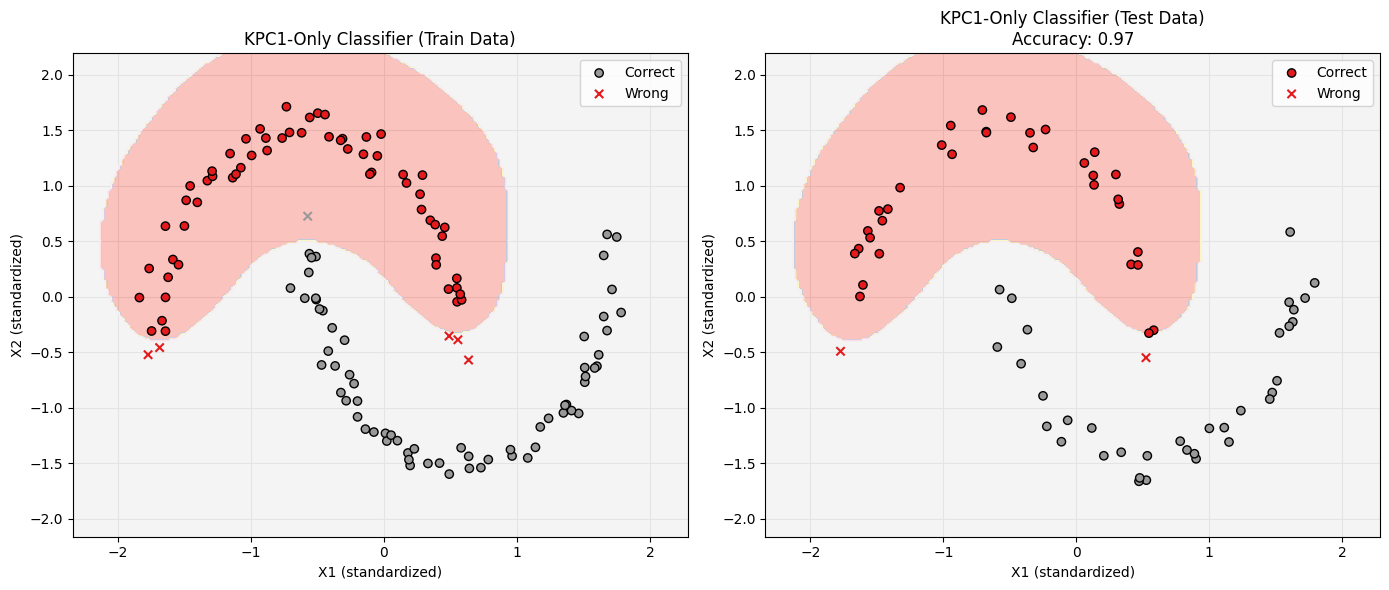

In [26]:
# === Step 1: Create meshgrid in original standardized space
h = 0.02
X_std = df_scaled[["X1", "X2"]].values
x_min, x_max = X_std[:, 0].min() - 0.5, X_std[:, 0].max() + 0.5
y_min, y_max = X_std[:, 1].min() - 0.5, X_std[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]

# === Step 2: Project grid through KPCA, use only KPC1
grid_kpca_2d = kpca_pc1.transform(grid)        # shape (N, 2)
grid_kpc1_only = grid_kpca_2d[:, [0]]          # shape (N, 1)
Z = clf_kpc1.predict(grid_kpc1_only).reshape(xx.shape)

# === Step 3: Prepare prediction correctness masks
y_train = df_train["Label"].values
y_test = df_test["Label"].values

train_wrong = y_train_pred_kpc1 != y_train
train_correct = ~train_wrong
test_wrong = y_test_pred_kpc1 != y_test
test_correct = ~test_wrong

X_train = df_train[["X1", "X2"]].values
X_test = df_test[["X1", "X2"]].values

# === Step 4: Plot
plt.figure(figsize=(14, 6))

# === TRAIN PLOT ===
plt.subplot(1, 2, 1)
plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1, alpha=0.8)

plt.scatter(X_train[train_correct, 0], X_train[train_correct, 1],
            c=y_train[train_correct], cmap=plt.cm.Set1, edgecolor='k', label='Correct')
plt.scatter(X_train[train_wrong, 0], X_train[train_wrong, 1],
            c=y_train[train_wrong], cmap=plt.cm.Set1, edgecolor='k', marker='x', label='Wrong')

plt.title("KPC1-Only Classifier (Train Data)")
plt.xlabel("X1 (standardized)")
plt.ylabel("X2 (standardized)")
plt.legend()
plt.grid(True)

# === TEST PLOT ===
plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1, alpha=0.8)

plt.scatter(X_test[test_correct, 0], X_test[test_correct, 1],
            c=y_test[test_correct], cmap=plt.cm.Set1, edgecolor='k', label='Correct')
plt.scatter(X_test[test_wrong, 0], X_test[test_wrong, 1],
            c=y_test[test_wrong], cmap=plt.cm.Set1, edgecolor='k', marker='x', label='Wrong')

plt.title(f"KPC1-Only Classifier (Test Data)\nAccuracy: {test_acc_kpc1:.2f}")
plt.xlabel("X1 (standardized)")
plt.ylabel("X2 (standardized)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Concluding Remarks

In this analysis, we explored and compared **PCA** and **Kernel PCA** for dimensionality reduction and classification using logistic regression. Starting with the `make_moons` dataset—a synthetic, nonlinear dataset—we:

- Established a **baseline** using logistic regression on the raw standardized data.
- Applied **linear PCA** to reorient the data, finding that using both PCs preserved accuracy, but **dropping to PC1 alone caused a noticeable performance drop**.
- Introduced **Kernel PCA**, which leverages nonlinear transformations via the kernel trick, and showed that even with **only one nonlinear component (KPC1)**, classification accuracy improved.
- Tuned the `gamma` parameter for Kernel PCA to **maximize performance**, and visualized decision boundaries across all methods in both transformed and original spaces.

This study demonstrated that **nonlinear dimensionality reduction (Kernel PCA)** can significantly enhance the separability of data that is not linearly structured, even in low dimensions.

---

### Limitations of Kernel PCA

Despite its power, Kernel PCA has several limitations:

- It is a **one-way transformation** — there's no natural inverse to map back to the original feature space, making interpretation and downstream usage more challenging.
- **Parameter tuning** (e.g., `gamma`) is crucial and computationally expensive.
- It doesn't scale well to large datasets because it requires computing and storing the **full kernel matrix**.
- Unlike supervised techniques, Kernel PCA does not use label information, so it may not always preserve the class-separating structure unless carefully tuned.

---

### Comments on the Dataset

The `make_moons` dataset is synthetic, designed to **highlight nonlinear structure** with two interleaving half circles. While such clearly separable shapes are rare in real-world datasets, many practical problems (e.g., **image recognition, bioinformatics, anomaly detection**) involve complex, **nonlinear manifolds** where **linear methods fall short**.

Thus, synthetic datasets like `make_moons` are **valuable testbeds**—they provide controlled environments to understand how different techniques behave before applying them to more noisy, high-dimensional, real-world data.

---

In conclusion, this workflow illustrates how Kernel PCA can extract meaningful structure from nonlinear data and why it's a powerful—but nuanced—tool in the dimensionality reduction toolkit.
